In [38]:
import itertools
import operator
import sys
import os
from collections import defaultdict
import numpy as np
from tqdm import tqdm
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt


In [39]:
search_root = "/checkpoint/jth/neuraldb/final=true/"
checkpoint_name = "metrics_test.json"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)

checkpoint_name = "metrics_test.jsonl"
files.extend(glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True))

search_root = "/checkpoint/jth/neuraldb/experiment=oracle_large/"
checkpoint_name = "metrics_test.json"
files.extend(glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True))

print(len(files))

for file in files:
    if "pipeline" in file:
        print(file)

144
/checkpoint/jth/neuraldb/final=true/experiment=pipeline/dataset=ndb,model=t5-base,version=v0.5,pipeline=dpr/lr=5e-4/context=50,filters=null,max_queries=null/seed-1/metrics_test.json
/checkpoint/jth/neuraldb/final=true/experiment=pipeline/dataset=ndb,model=t5-base,version=v0.5,pipeline=dpr/lr=5e-4/context=50,filters=null,max_queries=null/seed-3/metrics_test.json
/checkpoint/jth/neuraldb/final=true/experiment=pipeline/dataset=ndb,model=t5-base,version=v0.5,pipeline=dpr/lr=5e-4/context=50,filters=null,max_queries=null/seed-4/metrics_test.json
/checkpoint/jth/neuraldb/final=true/experiment=pipeline/dataset=ndb,model=t5-base,version=v0.5,pipeline=dpr/lr=5e-4/context=50,filters=null,max_queries=null/seed-5/metrics_test.json
/checkpoint/jth/neuraldb/final=true/experiment=pipeline/dataset=ndb,model=t5-base,version=v0.5,pipeline=dpr/lr=5e-4/context=50,filters=null,max_queries=null/seed-2/metrics_test.json
/checkpoint/jth/neuraldb/final=true/experiment=pipeline/dataset=ndb,model=t5-base,vers

In [44]:
def expand(idx,chunk):

  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]
  return []

experiments = []
for file in files:
    chunks = file.replace(search_root.replace('experiment=oracle_large',""),"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data['context'] = int(data['context'])
    if "pipeline" in data:
        data["experiment"] = data["experiment"] + " " + data["pipeline"]

    experiments.append(data)

In [45]:
to_remove = []
for idx, experiment in enumerate(tqdm(experiments[::-1])):
    all_raw = []
    all_breakdown = defaultdict(dict)
    all_breakdown_strict = defaultdict(dict)

    with open(experiment['file']) as f:
        for line in f.readlines()[-4:]:
            if line[0] == "}":
                line = line[1:]
            try:
                partial_results = json.loads(line)

            except Exception as e:

                continue

            all_raw.extend(partial_results['test']['raw'])
            all_breakdown["breakdown_prop"].update(partial_results['test']['breakdown']["relation_type"].items())
            all_breakdown["breakdown_type"].update(partial_results['test']['breakdown']["query_type"].items())

            all_breakdown_strict["breakdown_prop"].update(partial_results['test']['strict_breakdown']["relation_type"].items())
            all_breakdown_strict["breakdown_type"].update(partial_results['test']['strict_breakdown']["query_type"].items())


    if len(all_raw) == 0 or experiment["experiment"] == "oracle_concat":
        to_remove.append(idx)

    experiment["EM"] = np.mean([rec[2] for rec in all_raw])
    experiment["EM_strict"] = np.mean([rec[3] for rec in all_raw])

    for k,v in all_breakdown["breakdown_prop"].items():
        experiment["prop_{}".format(k)] = np.mean(v)

    for k,v in all_breakdown["breakdown_type"].items():
        experiment["type_{}".format(k)] = np.mean(v)
        experiment["count_type_{}".format(k)] = len(v)

    for k,v in all_breakdown_strict["breakdown_type"].items():
        experiment["type_strict_{}".format(k)] = np.mean(v)

    experiment["raw"] = all_raw

print(len(experiments))

 31%|███       | 44/144 [00:02<00:08, 12.22it/s]/private/home/jth/anaconda3/envs/neuraldb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/private/home/jth/anaconda3/envs/neuraldb/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 144/144 [00:12<00:00, 11.80it/s]


144


In [64]:
results = pd.DataFrame(experiments).fillna(0)
results = results[(results["lr"] == "5e-4")]
print(len(results))
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col == "EM_strict" or col.startswith("type_"),results.columns)}
breakdown_cols = list(filter(lambda col: col.startswith("prop_"),results.columns))
query_cols = list(filter(lambda col: col.startswith("type_"),results.columns))

breakdown = pd.pivot_table(results, index=["experiment","model","context"],aggfunc=cols)
breakdown.to_csv("results_oracle.csv")
print(len(breakdown_cols))
pd.options.display.max_rows = 150
pd.options.display.max_columns = 150
breakdown

104
17


EM           EM_strict            \
                                           mean       std      mean       std   
experiment            model   context                                           
entire_database       t5-base 50       0.917520  0.008048  0.916621  0.008202   
iterate_database      t5-base 50       0.782750  0.002661  0.778945  0.002764   
                              100      0.823976  0.002496  0.818686  0.002887   
                              500      0.904914  0.000773  0.900101  0.000959   
                              1000     0.911215  0.002669  0.906270  0.002874   
                              2000     0.922054  0.001832  0.916984  0.001819   
                              5000     0.907692  0.001208  0.901332  0.001295   
                              7000     0.917084  0.002880  0.912248  0.002829   
                              10000    0.912935  0.002169  0.907837  0.002219   
oracle_large          t5-base 50       0.953912  0.001718  0.953167  0.001820   
pipeline big_dpr      t5-base 50       0.918083  0.003829  0.917233  0.003869   
pipeline dpr          t5-base 50       0.781198  0.001207  0.777368  0.001173   
search_database       t5-base 50       0.779235  0.002584  0.774687  0.002598   
                              100      0.821496  0.003235  0.816192  0.003014   
                              500      0.906787  0.001886  0.901537  0.001788   
                              1000     0.914795  0.003393  0.909335  0.003591   
                              2000     0.926690  0.001616  0.921259  0.000957   
                              5000     0.912413  0.002088  0.906313  0.002449   
                              7000     0.918523  0.001728  0.913224  0.001332   
                              10000    0.916685  0.005187  0.911331  0.005339   
search_database_large t5-base 50       0.799963  0.002108  0.796645  0.002081   

                                      type_atomic_boolean            \
                                                     mean       std   
experiment            model   context                                 
entire_database       t5-base 50                 0.992593  0.001506   
iterate_database      t5-base 50                 0.988911  0.003795   
                              100                0.988829  0.003732   
                              500                0.982615  0.005509   
                              1000               0.972628  0.004939   
                              2000               0.970753  0.004192   
                              5000               0.956304  0.003456   
                              7000               0.973905  0.004977   
                              10000              0.969630  0.007451   
oracle_large          t5-base 50                 0.993687  0.002525   
pipeline big_dpr      t5-base 50                 0.989255  0.002915   
pipeline dpr          t5-base 50                 0.984008  0.005464   
search_database       t5-base 50                 0.986806  0.002095   
                              100                0.984533  0.008474   
                              500                0.984183  0.001243   
                              1000               0.980480  0.006505   
                              2000               0.974301  0.008332   
                              5000               0.972015  0.004716   
                              7000               0.976648  0.007962   
                              10000              0.972328  0.005717   
search_database_large t5-base 50                 0.990939  0.003725   

                                      type_atomic_extractive            \
                                                        mean       std   
experiment            model   context                                    
entire_database       t5-base 50                    0.987445  0.002843   
iterate_database      t5-base 50                    0.975131  0.006861   
                         

In [47]:
for exp in experiments:
    if exp["experiment"] == "pipeline":
        e = filter(lambda item: item[4]["query_type"] == "set" and item[3] < 0.5,  exp["raw"])

        for result in e:
            print(result)

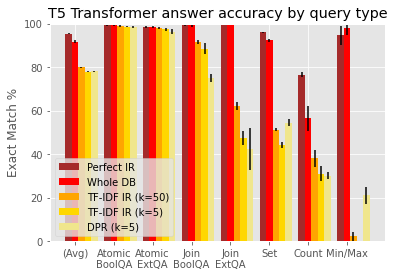

In [68]:
models = set(idx[0] for idx in breakdown.index)
lookup = {
    "EM":"(Avg)",
    "type_set":"Set",
          "type_count": "Count",
          "type_strict_min/max": "Min/Max",
          "type_join_boolean": "Join\nBoolQA",
          "type_strict_join_extractive": "Join\nExtQA",
          "type_atomic_boolean": "Atomic\nBoolQA",
          "type_strict_atomic_extractive":"Atomic\nExtQA"}

lookup2 = {
    "entire_database":"Whole DB",
    "oracle_large":"Perfect IR",
    "search_database": "TF-IDF IR (k=5)",
    "search_database_large": "TF-IDF IR (k=50)",
    "pipeline dpr": "DPR (k=5)",
    "pipeline big_dpr": "DPR (k=50)"
}


def doplot(model,count, cols=query_cols):
    means = []
    std = []

    for col in cols:
        means.append(breakdown[col]["mean"].T[model]["t5-base"][count])
        std.append(breakdown[col]["std"].T[model]["t5-base"][count])

    plt.figure(figsize=(5,4))
    plt.xticks(rotation=90)


    plt.title(f"Scores for queries over database with {count} facts {model}")
    plt.xlabel("Query Type")
    plt.ylabel("Exact Match %")
    plt.ylim(0,1)
    plt.bar([lookup[col] if col in lookup else col for col in cols], means, yerr=std)
    plt.tight_layout()

    return plt

def doplot_cmp(models, count, cols=query_cols):
    x = np.arange(len(cols))
    w = 1/(len(models)+1)
    plt.xticks(x+w, [lookup[col] if col in lookup else col for col in cols],rotation=0)
    plt.ylabel("Exact Match %")
    #colors = ["firebrick", "coral","rebeccapurple", "mediumpurple", "darkcyan","skyblue"]
    colors = ["brown","red","orange","gold","khaki"]
    for idx, model in enumerate(models):
        means = []
        std = []
        for col in cols:

            means.append(breakdown[col]["mean"].T[model]["t5-base"][count]*100)
            std.append(breakdown[col]["std"].T[model]["t5-base"][count]*100)


        plt.bar(x+idx*w,means,yerr=std, width=w, color=colors[idx])

    plt.ylim(0,100)
    plt.legend([lookup2[m] for m in models], loc='lower left', )# bbox_to_anchor=(1,-0.6))

    return plt

import matplotlib.pyplot as plt
with plt.style.context("ggplot"):
    # plt = doplot("oracle_concat",50, ["EM","query_atomic_boolean",
    #                                   "query_atomic_extractive",
    #                                   "query_join_boolean",
    #                                   "query_join_extractive",
    #                                   "query_set",
    #                                   "query_count",
    #                                   "query_min/max"
    #                                   ])

    plt = doplot_cmp([
        "oracle_large",
        "entire_database",
        #"pipeline big_dpr",
        "search_database_large",
        "search_database",
        "pipeline dpr",
    ],50, ["EM","type_atomic_boolean",
                                  "type_strict_atomic_extractive",
                                  "type_join_boolean",
                                  "type_strict_join_extractive",
                                  "type_set",
                                  "type_count",
                                  "type_strict_min/max"
                                  ])

    plt.title("T5 Transformer answer accuracy by query type")

    plt.savefig("/checkpoint/jth/neuraldb/t5_baselines.pdf")
    plt.show()



In [ ]:
with plt.style.context("ggplot"):
    for model in models:

        for count in breakdown["EM"]["mean"].T[model]["t5-base"].index:
            plt = doplot(model,count)
            plt.show()


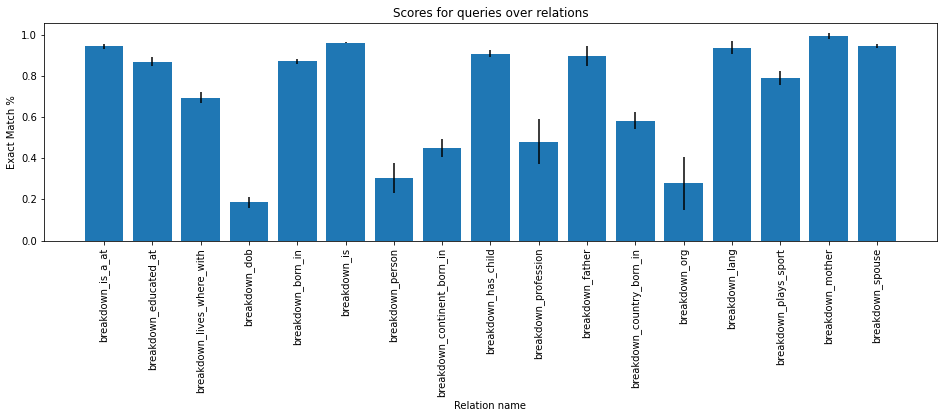

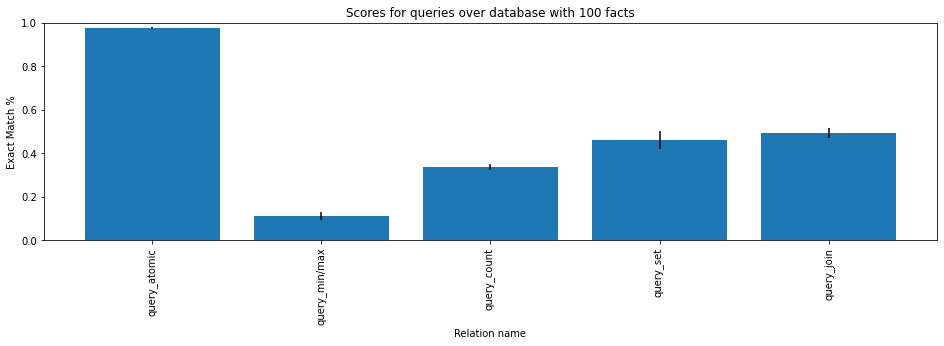

In [51]:

means = []
std = []

for col in breakdown_cols:

    means.append(breakdown[col]["mean"].T[model]["t5-base"]["100"])
    std.append(breakdown[col]["std"].T[model]["t5-base"]["100"])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("Scores for queries over relations")
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(breakdown_cols, means, yerr=std)
plt.show()


means = []
std = []

for col in query_cols:

    means.append(breakdown[col]["mean"].T[model]["t5-base"]["100"])
    std.append(breakdown[col]["std"].T[model]["t5-base"]["100"])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
plt.ylim(0,1)

plt.title("Scores for queries over database with 100 facts")
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(query_cols, means, yerr=std)
plt.show()